In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


import datetime as dt

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.main import check_and_make_directories
from pprint import pprint
from stable_baselines3.common.logger import configure

from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

from finrl.config_tickers import DOW_30_TICKER

import talib

# from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 

from sklearn.metrics import roc_auc_score, f1_score

%matplotlib inline

/Users/stureiko/miniforge3/envs/finrl/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Загружаем исходные данные

In [2]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2019-01-01'
TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2021-01-01'

# загружаем данные
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (88061, 8)


Преобразуем дату и сортируем датасет по дате и бумагам

In [3]:
# преобразуем дату
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Отсортируем данные по дате и коду акции
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.740172,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,42.107323,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.098144,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,30.837603,7117200,CAT,4


Выберем только бумаги Apple

In [4]:
data = df.loc[df['tic'] == 'AAPL']
data.drop(['tic', 'day'], axis=1, inplace=True)
data.head()

,date,open,high,low,close,volume
0,2009-01-02,3.067143,3.251429,3.041429,2.740172,746015200
29,2009-01-05,3.327500,3.435000,3.311071,2.855818,1181608400
58,2009-01-06,3.426786,3.470357,3.299643,2.808715,1289310400
87,2009-01-07,3.278929,3.303571,3.223571,2.748024,753048800
116,2009-01-08,3.229643,3.326786,3.215714,2.799052,673500800


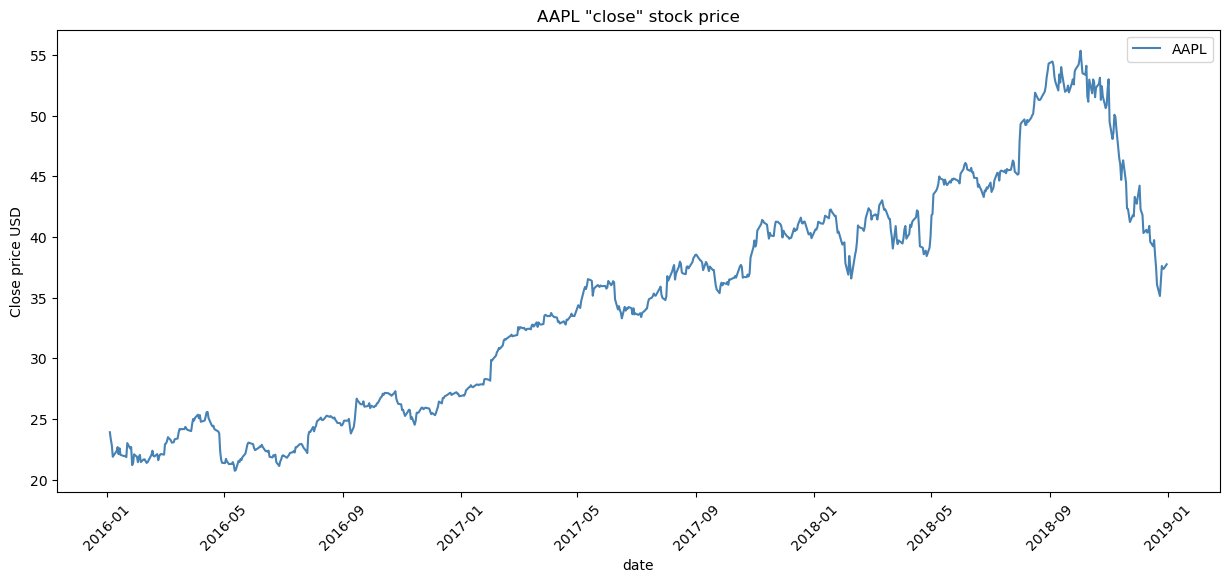

In [65]:
start_day = dt.datetime(2016, 1, 1)
end_day = dt.datetime(2019, 1, 1)
plt.figure(figsize=(15, 6))
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
         linestyle='-', color='steelblue', label='AAPL')
plt.title('AAPL "close" stock price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
plt.show()

## Технический анализ

Будем формировать показатели с использованием библиотеки TA-Lib (https://ta-lib.org)

Сколько всего индикаторов есть в библиотеке TA-Lib

In [6]:
len(talib.get_functions())

158

Какие группы индикаторы есть в библиотеке TA-Lib

In [7]:
list(talib.get_function_groups().keys())

['Cycle Indicators',
 'Math Operators',
 'Math Transform',
 'Momentum Indicators',
 'Overlap Studies',
 'Pattern Recognition',
 'Price Transform',
 'Statistic Functions',
 'Volatility Indicators',
 'Volume Indicators']

Посмотрм на индикаторы определенной группы

In [8]:
talib.get_function_groups()['Volatility Indicators']

['ATR', 'NATR', 'TRANGE']

### Простое скользящее среднее (Simple Moving Averages - SMA)

Скользящие средние - один из самых популярных технических индикаторов, используемых для сглаживания ценовых колебаний и выявления трендов. Они могут рассчитываться с использованием различных временных периодов, таких как краткосрочный (10 дней), среднесрочный (50 дней) и долгосрочный (200 дней).

50-дневная SMA/EMA: Один из наиболее популярных периодов, используется для анализа среднесрочных трендов и часто применяется в сочетании с 200-дневной SMA для выявления "золотого пересечения" (golden cross) и "мёртвого пересечения" (death cross).

In [9]:
data["sma_5"] = talib.SMA(data["close"], timeperiod=5)
data["sma_10"] = talib.SMA(data["close"], timeperiod=10)
data["sma_15"] = talib.SMA(data["close"], timeperiod=15)
data["sma_20"] = talib.SMA(data["close"], timeperiod=20)
data["sma_50"] = talib.SMA(data["close"], timeperiod=50)
data["sma_200"] = talib.SMA(data["close"], timeperiod=200)
data["sma_ratio_5_15"] = data['sma_15'] / data['sma_5']
data["sma_ratio_10_50"] = data['sma_50'] / data['sma_15']
data['sma_5_Volume'] = talib.SMA(data["volume"], timeperiod=5)
data['sma_10_Volume'] = talib.SMA(data["volume"], timeperiod=10)
data['sma_15_Volume'] = talib.SMA(data["volume"], timeperiod=15)
data['sma_50_Volume'] = talib.SMA(data["volume"], timeperiod=50)
data["sma_Volume_ratio_5_15"] = data['sma_5_Volume'] / data['sma_15_Volume']
data["sma_Volume_ratio_10_50"] = data['sma_10_Volume'] / data['sma_50_Volume']

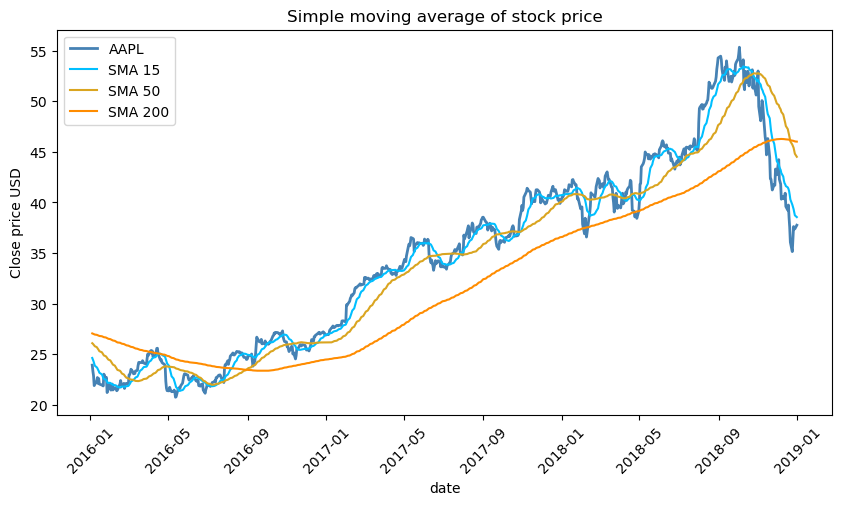

In [10]:
start_day = dt.datetime(2016, 1, 1)
end_day = dt.datetime(2019, 1, 1)
plt.figure(figsize=(10, 5))
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
         linestyle='-', linewidth=2, color='steelblue', label='AAPL')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['sma_15'], 
         linestyle='-', color='deepskyblue', label='SMA 15')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['sma_50'], 
         linestyle='-', color='goldenrod', label='SMA 50')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['sma_200'], 
         linestyle='-', color='darkorange', label='SMA 200')
plt.title('Simple moving average of stock price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
# plt.savefig('img/sma.png')
plt.show()

In [11]:
data["ema_5"] = talib.EMA(data["close"], timeperiod=5)
data["ema_10"] = talib.EMA(data["close"], timeperiod=10)
data["ema_20"] = talib.EMA(data["close"], timeperiod=20)
data["ema_50"] = talib.EMA(data["close"], timeperiod=50)
data["ema_200"] = talib.EMA(data["close"], timeperiod=200)

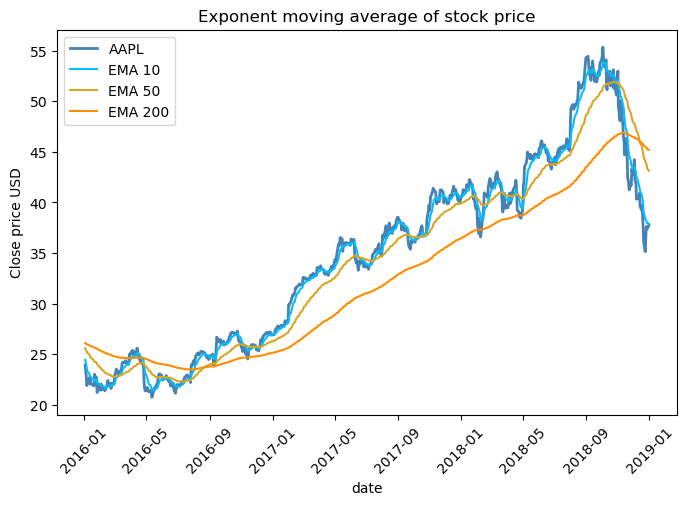

In [12]:
start_day = dt.datetime(2016, 1, 1)
end_day = dt.datetime(2019, 1, 1)
plt.figure(figsize=(8, 5))
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
         linestyle='-', linewidth=2, color='steelblue', label='AAPL')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['ema_10'], 
         linestyle='-', color='deepskyblue', label='EMA 10')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['ema_50'], 
         linestyle='-', color='goldenrod', label='EMA 50')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['ema_200'], 
         linestyle='-', color='darkorange', label='EMA 200')
plt.title('Exponent moving average of stock price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
# plt.savefig('img/ema.png')
plt.show()

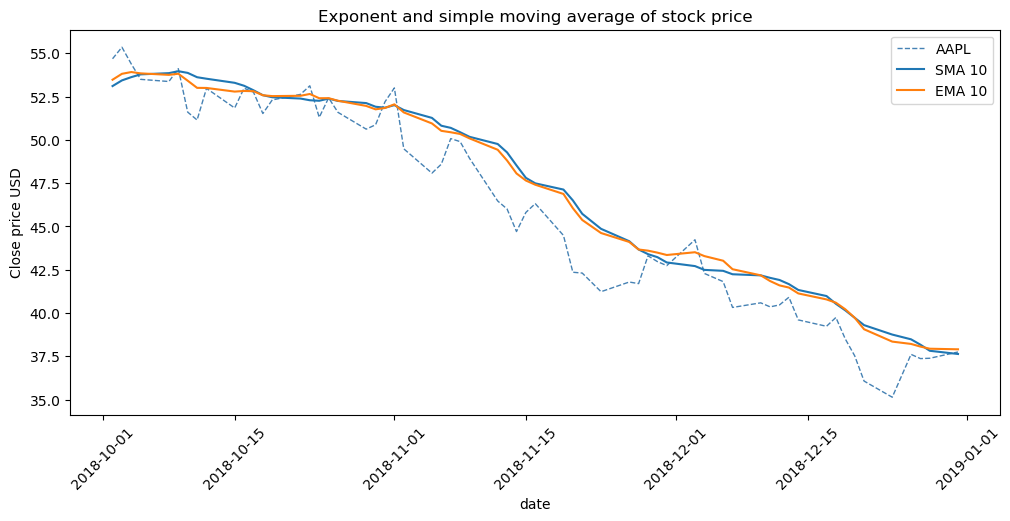

In [13]:
start_day = dt.datetime(2018, 10, 1)
end_day = dt.datetime(2019, 1, 1)
plt.figure(figsize=(12, 5))
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
         linestyle='--', linewidth=1, color='steelblue', label='AAPL')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['sma_10'], 
         linestyle='-', label='SMA 10')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['ema_10'], 
         linestyle='-', label='EMA 10')
plt.title('Exponent and simple moving average of stock price')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
plt.show()

### Полосы Боллинджера (Bollinger Bands)

Полосы Боллинджера используются для измерения волатильности актива и выявления условий перекупленности и перепроданности. Полосы состоят из скользящей средней (обычно 20-дневной скользящей средней) и двух линий стандартного отклонения выше и ниже скользящей средней.

#### Идентификация волатильности:
- Когда полосы расширяются/сужаются, это указывает на увеличение/снижение волатильности.
#### Сигналы на покупку и продажу:
- Когда цена актива пересекает верхнюю полосу, это может быть сигналом перекупленности и возможного разворота вниз.
- Когда цена актива пересекает нижнюю полосу, это может быть сигналом перепроданности и возможного разворота вверх.
#### Торговля на отскок:
- Трейдеры могут использовать полосы Боллинджера для торговли на отскок, покупая, когда цена касается нижней полосы, и продавая, когда она касается верхней полосы.
#### Подтверждение трендов:
- Если цена постоянно прикасается к верхней полосе в восходящем тренде или к нижней полосе в нисходящем тренде, это может служить подтверждением силы текущего тренда.


In [14]:
# Calculate the Bollinger Bands
data["upper_band"], data["middle_band"], data["lower_band"] = talib.BBANDS(data["close"], timeperiod=20)

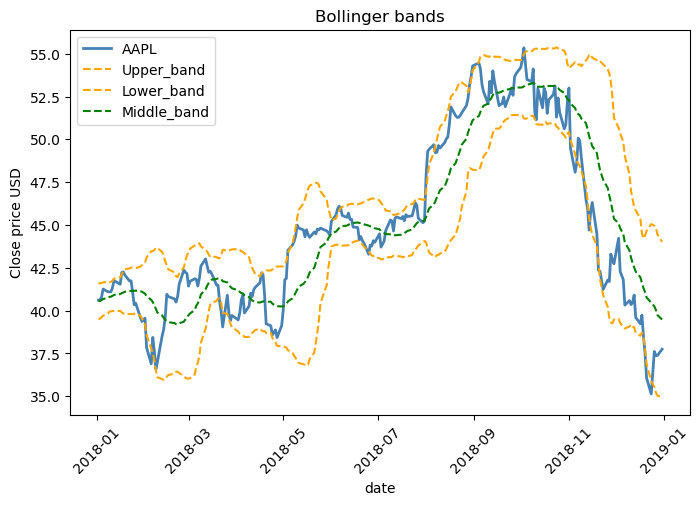

In [15]:
start_day = dt.datetime(2018, 1, 1)
end_day = dt.datetime(2019, 1, 1)
plt.figure(figsize=(8, 5))
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
         linestyle='-', linewidth=2, color='steelblue', label='AAPL')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['upper_band'], 
         linestyle='--', color='orange', label='Upper_band')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['lower_band'], 
         linestyle='--', color='orange', label='Lower_band')
plt.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['middle_band'], 
         linestyle='--', color='green', label='Middle_band')
plt.title('Bollinger bands')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ylabel('Close price USD')
plt.legend()
plt.show()

### Индекс относительной силы (Relative Strength Index - RSI)

RSI - это индикатор импульса, который сравнивает величину недавних достижений с недавними потерями, чтобы определить условия перекупленности и перепроданности. Обычно он используется с 14-дневным периодом.

#### Идентификация волатильности:
- Когда полосы расширяются/сужаются, это указывает на увеличение/снижение волатильности.
#### Определение перекупленности и перепроданности:
- Когда RSI выше 70, это может указывать на перекупленность актива, и трейдеры могут рассматривать возможность продажи.
- Когда RSI ниже 30, это может указывать на перепроданность актива, и трейдеры могут рассматривать возможность покупки.
#### Сигналы на пересечении:
- Некоторые трейдеры используют пересечение уровня 50 в RSI как сигнал на покупку или продажу. Когда RSI пересекает уровень 50 сверху вниз, это может быть сигналом на продажу, и наоборот.


In [16]:
# Calculate the relative strength index (RSI)
data["RSI"] = talib.RSI(data["close"], timeperiod=14)

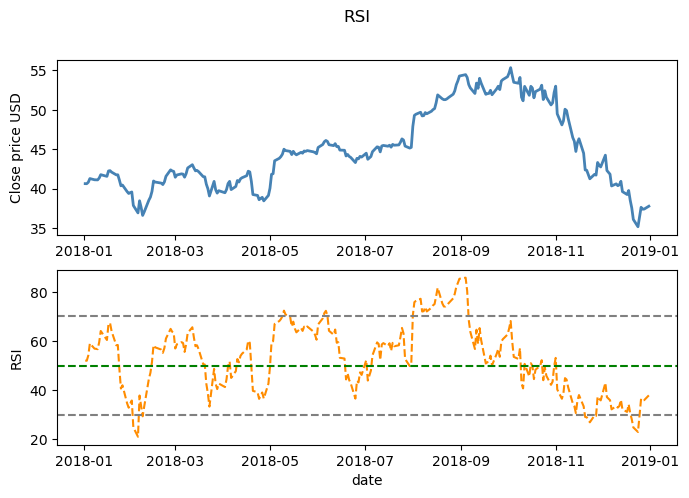

In [17]:
start_day = dt.datetime(2018, 1, 1)
end_day = dt.datetime(2019, 1, 1)

fig, axs = plt.subplots(2, figsize=(8, 5))

axs[0].plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
         linestyle='-', linewidth=2, color='steelblue', label='AAPL')
axs[1].plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['RSI'], 
         linestyle='--', color='darkorange', label='RSI')
axs[1].axhline(y=30, color='grey', linestyle='--')
axs[1].axhline(y=70, color='grey', linestyle='--')
axs[1].axhline(y=50, color='green', linestyle='--')

axs[1].set_xlabel('date')
axs[0].set_ylabel('Close price USD')
axs[1].set_ylabel('RSI')

fig.suptitle('RSI')
plt.show()

### Дивергенция сходимости скользящих средних (Moving Average Convergence Divergence - MACD)

MACD - это индикатор следования за трендом, который измеряет разницу между краткосрочной скользящей средней и долгосрочной скользящей средней. Обычно он используется с 12-дневной и 26-дневной скользящей средней, а также с 9-дневной сигнальной линией.

#### Пересечение MACD и сигнальной линии:
- Когда линия MACD пересекает сигнальную линию снизу вверх, это считается бычьим сигналом на покупку.
- Когда линия MACD пересекает сигнальную линию сверху вниз, это считается медвежьим сигналом на продажу.
#### Положение линии MACD относительно нулевой линии:
- Когда линия MACD находится выше нулевой линии, это указывает на восходящий тренд.
- Когда линия MACD находится ниже нулевой линии, это указывает на нисходящий тренд.


In [18]:
# Calculate the MACD
data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data["close"], fastperiod=12, slowperiod=26, signalperiod=9)

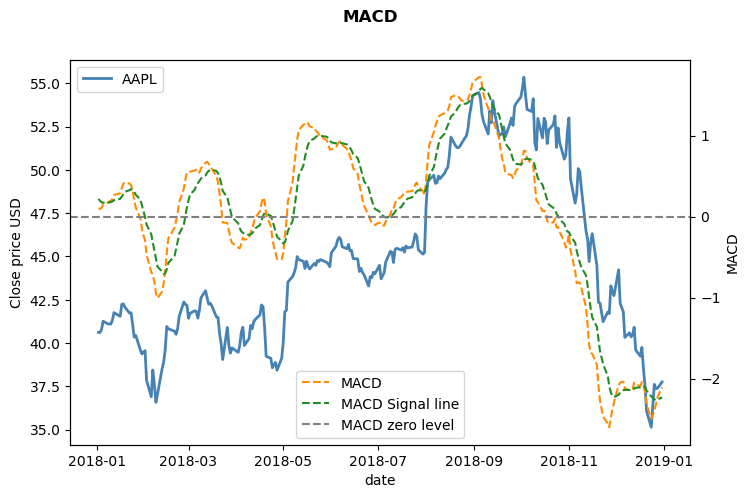

In [19]:
start_day = dt.datetime(2018, 1, 1)
end_day = dt.datetime(2019, 1, 1)

fig, ax = plt.subplots(figsize=(8, 5))

ax2 = ax.twinx()

ax.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
         linestyle='-', linewidth=2, color='steelblue', label='AAPL')
ax2.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['macd'], 
         linestyle='--', color='darkorange', label='MACD')
ax2.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['macd_signal'], 
         linestyle='--', color='forestgreen', label='MACD Signal line')
ax2.axhline(y=0, color='grey', linestyle='--', label='MACD zero level')

ax.set_xlabel('date')
ax.set_ylabel('Close price USD')
ax2.set_ylabel('MACD')

fig.suptitle('MACD', fontweight="bold")
ax.legend(loc='upper left')
ax2.legend(loc='lower center')
plt.show()

### Индекс средней направленности (ADX)

Индекс средней направленности был разработан Уайлдером для оценки силы тренда в ценах на акции. 

Два его основных компонента, +DI и -DI, помогают определить направление тренда. ADX указывает только на силу тренда, но не его направление.

#### Сила тренда:
- Значения выше 25 указывают на сильный тренд.
- Значения ниже 20 указывают на слабый тренд.


In [20]:
data['ADX_5'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=5)
data['ADX_15'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=15)

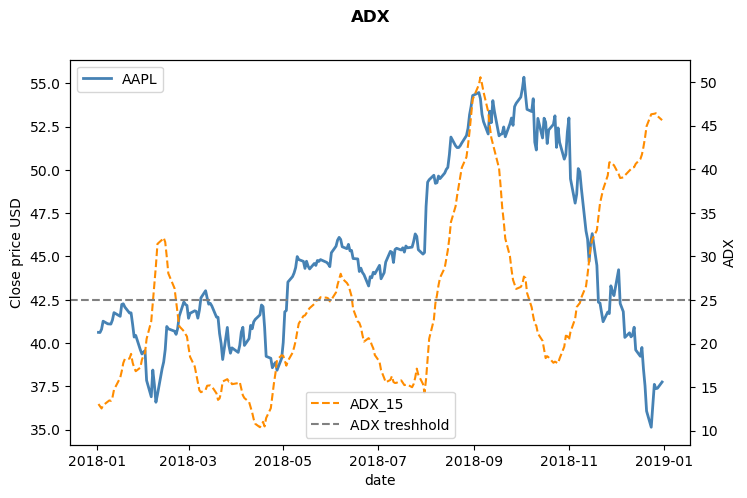

In [21]:
start_day = dt.datetime(2018, 1, 1)
end_day = dt.datetime(2019, 1, 1)

fig, ax = plt.subplots(figsize=(8, 5))

ax2 = ax.twinx()

ax.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['close'], 
         linestyle='-', linewidth=2, color='steelblue', label='AAPL')
ax2.plot(data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['date'], 
         data.loc[(data['date'] < end_day) & (data['date'] > start_day)]['ADX_15'], 
         linestyle='--', color='darkorange', label='ADX_15')
ax2.axhline(y=25, color='grey', linestyle='--', label='ADX treshhold')

ax.set_xlabel('date')
ax.set_ylabel('Close price USD')
ax2.set_ylabel('ADX')

fig.suptitle('ADX', fontweight="bold")
ax.legend(loc='upper left')
ax2.legend(loc='lower center')
plt.show()

### Индекс относительной силы (RSI)

RSI - один из наиболее распространенных индикаторов импульса, призванный количественно оценить изменение цены и скорость этого изменения.

In [22]:
data['RSI_5'] = talib.RSI(data['close'], timeperiod=5)
data['RSI_15'] = talib.RSI(data['close'], timeperiod=15)
data['RSI_ratio'] = data['RSI_5']/data['RSI_15']

### Скорость изменения (Rate of Change)

Темп изменения - это индикатор импульса, который объясняет динамику цены по отношению к цене, зафиксированной периодом ранее.

In [23]:
data['ROC'] = talib.ROC(data['close'], timeperiod=15)

## Моделирование

In [24]:
data['target'] = np.where(data['close'].diff() > 1, True, False)
data['diff'] = data['close'].diff()
data.dropna(inplace=True)

In [25]:
data.head()

,date,open,high,low,close,volume,sma_5,sma_10,sma_15,sma_20,...,macd_signal,macd_hist,ADX_5,ADX_15,RSI_5,RSI_15,RSI_ratio,ROC,target,diff
5771,2009-10-16,6.762500,6.798571,6.708571,5.678120,431426800,5.741410,5.727188,5.675384,5.645783,...,0.137899,-0.014397,35.700643,27.286972,40.734611,59.855203,0.680553,3.114509,False,-0.075791
5800,2009-10-19,6.708929,6.785714,6.626786,5.732772,942230800,5.735672,5.738783,5.682852,5.654599,...,0.133860,-0.016155,36.772550,25.937123,54.799894,62.737953,0.873473,1.993015,False,0.054653
5829,2009-10-20,7.164286,7.205357,7.066071,6.001504,1141039200,5.788452,5.765203,5.709785,5.676158,...,0.133740,-0.000480,40.849290,26.987368,81.616241,72.965426,1.118560,7.217599,False,0.268732
5858,2009-10-21,7.125714,7.453929,7.115357,6.187505,1193726800,5.870762,5.809498,5.749179,5.705477,...,0.138745,0.020020,47.025504,28.711277,87.851809,77.537534,1.133023,10.558356,False,0.186000
5887,2009-10-22,7.310714,7.423214,7.232500,6.195960,791392000,5.959172,5.857598,5.798175,5.737756,...,0.146519,0.031095,51.966475,30.320259,88.081510,77.721038,1.133303,13.457888,False,0.008455


In [26]:
features = ['sma_5', 'sma_10', 'sma_15', 'sma_50', 'sma_200', 'sma_ratio_5_15', 'sma_ratio_10_50', 
            'sma_5_Volume', 'sma_10_Volume', 'sma_15_Volume', 'sma_50_Volume', 'sma_Volume_ratio_5_15', 'sma_Volume_ratio_10_50', 'upper_band',
            'middle_band', 'lower_band', 'RSI', 'macd', 'macd_signal', 'macd_hist',
            'ADX_5', 'ADX_15', 'RSI_5', 'RSI_15', 'RSI_ratio', 'ROC']

In [27]:
X = data[features]
y = data["target"]

In [28]:
n = 0.90
idx = int(X.shape[0]//(1/(1-n)))
train_index = X.shape[0] - idx
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

In [29]:
X_train.shape, X_test.shape

((2540, 26), (282, 26))

In [56]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=False).fit(X_train, y_train)
sklearn_GB_roc_auc_score = roc_auc_score(y_test, gbm.predict_proba(X_test)[:, 1])
sklearn_GB_f1_score = f1_score(y_test, gbm.predict(X_test))
sklearn_GB_accuracy = accuracy_score(y_test, gbm.predict(X_test))
sklearn_GB_precision = precision_score(y_test, gbm.predict(X_test))
sklearn_GB_recall = recall_score(y_test, gbm.predict(X_test))

In [57]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
clf = LGBMClassifier(n_estimators=300, verbosity=-1)
clf.fit(X_train, y_train)

LightGBM_roc_auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
LightGBM_f1_score = f1_score(y_test, clf.predict(X_test))
LightGBM_accuracy = accuracy_score(y_test, clf.predict(X_test))
LightGBM_precision = precision_score(y_test, clf.predict(X_test))
LightGBM_recall = recall_score(y_test, clf.predict(X_test))

In [58]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)

CatBoost_roc_auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
CatBoost_f1_score = f1_score(y_test, clf.predict(X_test))
CatBoost_accuracy = accuracy_score(y_test, clf.predict(X_test))
CatBoost_precision = precision_score(y_test, clf.predict(X_test))
CatBoost_recall = recall_score(y_test, clf.predict(X_test))

In [64]:
print('Total score\t\t\tROC_AUC\t\tF1\tAccuracy\tPrecision\tRecall')
print(f'sklearn gradient boosting:\t{sklearn_GB_roc_auc_score:.4f}\t\t{sklearn_GB_f1_score:.4f}\t{sklearn_GB_accuracy:.4f}\t\t{sklearn_GB_precision:.4f}\t\t{sklearn_GB_recall:.4f}')
print(f'LightGBM gradient boosting:\t{LightGBM_roc_auc_score:.4f}\t\t{LightGBM_f1_score:.4f}\t{LightGBM_accuracy:.4f}\t\t{LightGBM_precision:.4f}\t\t{LightGBM_recall:.4f}')
print(f'CatBoost gradient boosting:\t{CatBoost_roc_auc_score:.4f}\t\t{CatBoost_f1_score:.4f}\t{CatBoost_accuracy:.4f}\t\t{CatBoost_precision:.4f}\t\t{CatBoost_recall:.4f}')

Total score			ROC_AUC		F1	Accuracy	Precision	Recall
sklearn gradient boosting:	0.6172		0.4410	0.6135		0.4216		0.4624
LightGBM gradient boosting:	0.6810		0.2903	0.6879		0.5806		0.1935
CatBoost gradient boosting:	0.7188		0.2456	0.6950		0.6667		0.1505
